# Multi-class Classification and Neural Networks

## 1 Multi-class classification

For this excercise, you will use logistic regression to recognize handwritten digits (from 0 to 9). Multi-class classification is performed on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset using one-vs-all classification.

### 1.1 Dataset

There are 5000 training examples in *ex3data1.mat*, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This results in a 5000 by 400 matrix **X** where every row is a training
example for a handwritten digit image.

In [1]:
# imports 
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# loading the dataset from ex3data1.mat file
dataset = sio.loadmat('ex3data1.mat')
dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [14]:
X = dataset['X']
y = dataset['y']
print(f'Training data X shape: {X.shape}')
print(f'Labels y shape: {y.shape}')

Training data X shape: (5000, 400)
Labels y shape: (5000, 1)


### 1.2 Visualizing the data

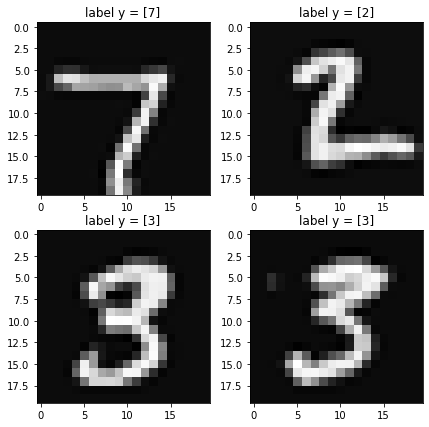

In [49]:
rand_indices = np.random.randint(low=0, high=X.shape[0], size=4)
plt.figure(figsize=(7,7))
for i, rand_index in enumerate(rand_indices):
    plt.subplot(2,2,i+1)
    plt.title(f'label y = {y[rand_index]}')
    plt.gray()
    plt.imshow(X[rand_index].reshape(20,20).T)

### 1.3 Vectorized (regularized) logististic regression

It is much easier to write code (not to say, much more computationally efficient) in vectorized form rather using loops. 

Logistic regression hypothesis is defined as:
$$ h_{\theta}(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function defined as:
$$ g(z) = \frac{1}{1+e^{-z}} $$

Cost function in logistic regression is (no regularization parameter):
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{i})) - (1-y^{(i)})\log(1-h_{\theta}(x^{i}))] $$

and the gradient of regularizationthe cost is a vector of the same length as $ \theta $ where the $ j^{th} $ element (for $ j $ = 0, 1, ..., n) is defined as follows:
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)} $$

Regularized cost function in logistic regression is:

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{i})) - (1-y^{(i)})\log(1-h_{\theta}(x^{i}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

where hypothesis is the same sigmoid activation function as in non-regularized logistic regression. 
The only new parameter is the regularized parameter $\lambda$.

Gradient of the cost is a vector of the same length as $ \theta $ where the $ j^{th} $ element (for $ j $ = 0, 1, ..., n) is defined as follows:
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)};  j=0$$
and
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)} + \frac{\lambda}{m}\theta_{j};  j\geq0$$

Hint:

Vectorized form of regularized gradient descent for logistic regression can be written as:
$$ \begin{bmatrix}
    \frac{\partial J}{\partial \theta_{0}}\\
    \frac{\partial J}{\partial \theta_{1}}\\
    \frac{\partial J}{\partial \theta_{2}}\\
    ...\\
    \frac{\partial J}{\partial \theta_{n}}
    \end{bmatrix} = \frac{1}{m}X^T(h_{\theta}(x) - y) + \frac{\lambda}{m} \theta
$$